# Chapter 4

This is the fourth in a series of notebooks related to astronomy data.

As a running example, we are replicating parts of the analysis in a recent paper, "[Off the beaten path: Gaia reveals GD-1 stars outside of the main stream](https://arxiv.org/abs/1805.00425)" by Adrian M. Price-Whelan and Ana Bonaca.

In the first lesson, we wrote ADQL queries and used them to select and download data from the Gaia server.

In the second lesson, we write a query to select stars from the region of the sky where we expect GD-1 to be, and save the results in a FITS file.

In the third lesson, we read that data back and identified stars with the proper motion we expect for GD-1.

## Outline

Here are the steps in this lesson:

1. Using data from the previous lesson, we'll identify the values of proper motion for stars likely to be in GD-1.

2. Then we'll compose an ADQL query that selects stars based on proper motion, so we can download only the data we need.

3. We'll also see how to write the results to a CSV file.

That will make it possible to search a bigger region of the sky in a single query.

After completing this lesson, you should be able to

* Convert proper motion between frames.

* Write an ADQL query that selects based on proper motion.

## Installing libraries

If you are running this notebook on Colab, you can run the following cell to install Astroquery and the other libraries we'll use.

If you are running this notebook on your own computer, you might have to install these libraries yourself.  See the instructions in the preface.

In [1]:
# If we're running on Colab, install libraries

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install astroquery astro-gala pyia python-wget

## Reload the data

The following cells download the data from the previous lesson, if necessary, and load it into a Pandas `DataFrame`.

In [2]:
import os
from wget import download

filename = 'gd1_dataframe.hdf5'
path = 'https://github.com/AllenDowney/AstronomicalData/raw/main/data/'

if not os.path.exists(filename):
    print(download(path+filename))

In [3]:
import pandas as pd

df = pd.read_hdf(filename, 'df')
centerline = pd.read_hdf(filename, 'centerline')
selected = pd.read_hdf(filename, 'selected')

## Selection by proper motion

At this point we have downloaded data for a relatively large number of stars (more than 100,000) and selected a relatively small number (around 1000).

It would be more efficient to use ADQL to select only the stars we need.  That would also make it possible to download data covering a larger region of the sky.

However, the selection we did was based on proper motion in the `GD1Koposov10` frame.  In order to do the same selection in ADQL, we have to work with proper motions in ICRS.

As a reminder, here's the rectangle we selected based on proper motion in the `GD1Koposov10` frame.

In [4]:
pm1_min = -8.9
pm1_max = -6.9
pm2_min = -2.2
pm2_max =  1.0

In [5]:
import astropy.units as u

pm1_rect = [pm1_min, pm1_min, pm1_max, pm1_max, pm1_min] * u.mas/u.yr
pm2_rect = [pm2_min, pm2_max, pm2_max, pm2_min, pm2_min] * u.mas/u.yr

The following figure shows:

* Proper motion for the stars we selected along the center line of GD-1,

* The rectangle we selected, and

* The stars inside the rectangle highlighted in green.

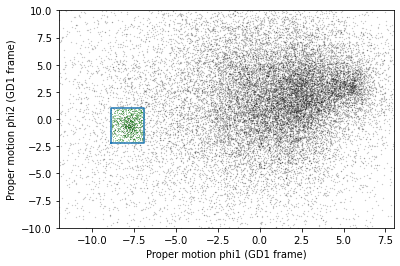

In [6]:
import matplotlib.pyplot as plt

pm1 = centerline['pm_phi1']
pm2 = centerline['pm_phi2']
plt.plot(pm1, pm2, 'ko', markersize=0.3, alpha=0.3)

pm1 = selected['pm_phi1']
pm2 = selected['pm_phi2']
plt.plot(pm1, pm2, 'gx', markersize=0.3, alpha=0.3)

plt.plot(pm1_rect, pm2_rect, '-')
    
plt.xlabel('Proper motion phi1 (GD1 frame)')
plt.ylabel('Proper motion phi2 (GD1 frame)')

plt.xlim(-12, 8)
plt.ylim(-10, 10);

Now we'll make the same plot using proper motions in the ICRS frame, which are stored in columns `pmra` and `pmdec`.

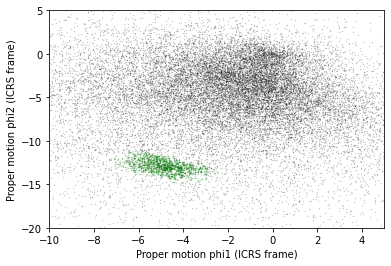

In [7]:
pm1 = centerline['pmra']
pm2 = centerline['pmdec']
plt.plot(pm1, pm2, 'ko', markersize=0.3, alpha=0.3)

pm1 = selected['pmra']
pm2 = selected['pmdec']
plt.plot(pm1, pm2, 'gx', markersize=1, alpha=0.3)
    
plt.xlabel('Proper motion ra (ICRS frame)')
plt.ylabel('Proper motion dec (ICRS frame)')

plt.xlim([-10, 5])
plt.ylim([-20, 5]);

The proper motions of the selected stars are more spread out in this frame, which is why it was preferable to do the selection in the GD-1 frame.

But now we can define a polygon that encloses the proper motions of these stars in ICRS, 
and use the polygon as a selection criterion in an ADQL query.

SciPy provides a function that computes the [convex hull](https://en.wikipedia.org/wiki/Convex_hull) of a set of points, which is the smallest convex polygon that contains all of the points.

To use it, I'll select columns `pmra` and `pmdec` and convert them to a NumPy array.

In [8]:
import numpy as np

points = selected[['pmra','pmdec']].to_numpy()
points.shape

(1049, 2)

NOTE: If you are using an older version of Pandas, you might not have `to_numpy()`; you can use `values` instead, like this:

```
points = selected[['pmra','pmdec']].values

```

We'll pass the points to `ConvexHull`, which returns an object that contains the results. 

In [9]:
from scipy.spatial import ConvexHull

hull = ConvexHull(points)
hull

`hull.vertices` contains the indices of the points that fall on the perimeter of the hull.

In [10]:
hull.vertices

array([ 692,  873,  141,  303,   42,  622,   45,   83,  127,  182, 1006,
        971,  967, 1001,  969,  940], dtype=int32)

We can use them as an index into the original array to select the corresponding rows.

In [11]:
pm_vertices = points[hull.vertices]
pm_vertices

array([[ -4.05037121, -14.75623261],
       [ -3.41981085, -14.72365546],
       [ -3.03521988, -14.44357135],
       [ -2.26847919, -13.7140236 ],
       [ -2.61172203, -13.24797471],
       [ -2.73471401, -13.09054471],
       [ -3.19923146, -12.5942653 ],
       [ -3.34082546, -12.47611926],
       [ -5.67489413, -11.16083338],
       [ -5.95159272, -11.10547884],
       [ -6.42394023, -11.05981295],
       [ -7.09631023, -11.95187806],
       [ -7.30641519, -12.24559977],
       [ -7.04016696, -12.88580702],
       [ -6.00347705, -13.75912098],
       [ -4.42442296, -14.74641176]])

To plot the resulting polygon, we have to pull out the x and y coordinates.

In [12]:
pmra_poly, pmdec_poly = np.transpose(pm_vertices)

The following figure shows proper motion in ICRS again, along with the convex hull we just computed.

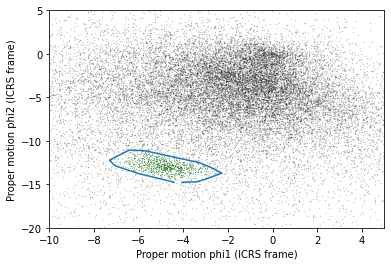

In [13]:
pm1 = centerline['pmra']
pm2 = centerline['pmdec']
plt.plot(pm1, pm2, 'ko', markersize=0.3, alpha=0.3)

pm1 = selected['pmra']
pm2 = selected['pmdec']
plt.plot(pm1, pm2, 'gx', markersize=0.3, alpha=0.3)

plt.plot(pmra_poly, pmdec_poly)
    
plt.xlabel('Proper motion phi1 (ICRS frame)')
plt.ylabel('Proper motion phi2 (ICRS frame)')

plt.xlim([-10, 5])
plt.ylim([-20, 5]);

To use `pm_vertices` as part of an ADQL query, we have to convert it to a string.

We'll use `flatten` to convert from a 2-D array to a 1-D array, and `str` to convert each element to a string.

In [14]:
t = [str(x) for x in pm_vertices.flatten()]
t

['-4.050371212154984',
 '-14.75623260987968',
 '-3.4198108491382455',
 '-14.723655456335619',
 '-3.035219883740934',
 '-14.443571352854612',
 '-2.268479190206636',
 '-13.714023598831554',
 '-2.611722027231764',
 '-13.247974712069263',
 '-2.7347140078529106',
 '-13.090544709622938',
 '-3.199231461993783',
 '-12.594265302440828',
 '-3.34082545787549',
 '-12.476119260818695',
 '-5.674894125178565',
 '-11.160833381392624',
 '-5.95159272432137',
 '-11.105478836426514',
 '-6.423940229776128',
 '-11.05981294804957',
 '-7.096310230579248',
 '-11.951878058650085',
 '-7.306415190921692',
 '-12.245599765990594',
 '-7.040166963232815',
 '-12.885807024935527',
 '-6.0034770546523735',
 '-13.759120984106968',
 '-4.42442296194263',
 '-14.7464117578883']

Now `t` is a list of strings; we can use `join` to make a single string with commas between the elements.

In [15]:
pm_point_list = ', '.join(t)
pm_point_list

'-4.050371212154984, -14.75623260987968, -3.4198108491382455, -14.723655456335619, -3.035219883740934, -14.443571352854612, -2.268479190206636, -13.714023598831554, -2.611722027231764, -13.247974712069263, -2.7347140078529106, -13.090544709622938, -3.199231461993783, -12.594265302440828, -3.34082545787549, -12.476119260818695, -5.674894125178565, -11.160833381392624, -5.95159272432137, -11.105478836426514, -6.423940229776128, -11.05981294804957, -7.096310230579248, -11.951878058650085, -7.306415190921692, -12.245599765990594, -7.040166963232815, -12.885807024935527, -6.0034770546523735, -13.759120984106968, -4.42442296194263, -14.7464117578883'

## Selecting the region

Let's review how we got to this point.

1. We made an ADQL query to the Gaia server to get data for stars in the vicinity of GD-1.

2. We transformed to `GD1` coordinates so we could select stars along the centerline of GD-1.

3. We plotted the proper motion of the centerline stars to identify the bounds of the overdense region.

4. We made a mask that selects stars whose proper motion is in the overdense region.

The problem is that we downloaded data for more than 100,000 stars and selected only about 1000 of them.

It will be more efficient if we select on proper motion as part of the query.  That will allow us to work with a larger region of the sky in a single query, and download less unneeded data.

This query will select on the following conditions:

* `parallax < 1`

* `bp_rp BETWEEN -0.75 AND 2`

* Coordinates within a rectangle in the GD-1 frame, transformed to ICRS.

* Proper motion with the polygon we just computed.

The first three conditions are the same as in the previous query.  Only the last one is new.

Here's the rectangle in the GD-1 frame we'll select.

In [16]:
phi1_min = -70
phi1_max = -20
phi2_min = -5
phi2_max = 5

In [17]:
phi1_rect = [phi1_min, phi1_min, phi1_max, phi1_max] * u.deg
phi2_rect = [phi2_min, phi2_max, phi2_max, phi2_min] * u.deg

Here's how we transform it to ICRS, as we saw in the previous lesson.

In [18]:
import gala.coordinates as gc
import astropy.coordinates as coord

corners = gc.GD1Koposov10(phi1=phi1_rect, phi2=phi2_rect)
corners_icrs = corners.transform_to(coord.ICRS)

To use `corners_icrs` as part of an ADQL query, we have to convert it to a string.  Here's how we do that, as we saw in the previous lesson.

In [19]:
point_base = "{point.ra.value}, {point.dec.value}"

t = [point_base.format(point=point)
     for point in corners_icrs]

point_list = ', '.join(t)
point_list

'135.30559858565638, 8.398623940157561, 126.50951508623503, 13.44494195652069, 163.0173655836748, 54.24242734020255, 172.9328536286811, 46.47260492416258'

Now we have everything we need to assemble the query.

## Assemble the query

Here's the base string we used for the query in the previous lesson.

In [20]:
query_base = """SELECT 
{columns}
FROM gaiadr2.gaia_source
WHERE parallax < 1
  AND bp_rp BETWEEN -0.75 AND 2 
  AND 1 = CONTAINS(POINT(ra, dec), 
                   POLYGON({point_list}))
"""

**Exercise:** Modify `query_base` by adding a new clause to select stars whose coordinates of proper motion, `pmra` and `pmdec`, fall within the polygon defined by `pm_point_list`.

In [21]:
# Solution

query_base = """SELECT 
{columns}
FROM gaiadr2.gaia_source
WHERE parallax < 1
  AND bp_rp BETWEEN -0.75 AND 2 
  AND 1 = CONTAINS(POINT(ra, dec), 
                   POLYGON({point_list}))
  AND 1 = CONTAINS(POINT(pmra, pmdec),
                   POLYGON({pm_point_list}))
"""

Here again are the columns we want to select.

In [22]:
columns = 'source_id, ra, dec, pmra, pmdec, parallax, parallax_error, radial_velocity'

**Exercise:** Use `format` to format `query_base` and define `query`, filling in the values of `columns`, `point_list`, and `pm_point_list`.

In [23]:
# Solution

query = query_base.format(columns=columns, 
                            point_list=point_list,
                            pm_point_list=pm_point_list)
print(query)

SELECT 
source_id, ra, dec, pmra, pmdec, parallax, parallax_error, radial_velocity
FROM gaiadr2.gaia_source
WHERE parallax < 1
  AND bp_rp BETWEEN -0.75 AND 2 
  AND 1 = CONTAINS(POINT(ra, dec), 
                   POLYGON(135.30559858565638, 8.398623940157561, 126.50951508623503, 13.44494195652069, 163.0173655836748, 54.24242734020255, 172.9328536286811, 46.47260492416258))
  AND 1 = CONTAINS(POINT(pmra, pmdec),
                   POLYGON(-4.050371212154984, -14.75623260987968, -3.4198108491382455, -14.723655456335619, -3.035219883740934, -14.443571352854612, -2.268479190206636, -13.714023598831554, -2.611722027231764, -13.247974712069263, -2.7347140078529106, -13.090544709622938, -3.199231461993783, -12.594265302440828, -3.34082545787549, -12.476119260818695, -5.674894125178565, -11.160833381392624, -5.95159272432137, -11.105478836426514, -6.423940229776128, -11.05981294804957, -7.096310230579248, -11.951878058650085, -7.306415190921692, -12.245599765990594, -7.040166963232815, -12.8

Here's how we run it.

In [24]:
from astroquery.gaia import Gaia

job = Gaia.launch_job_async(query)
print(job)

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
INFO: Query finished. [astroquery.utils.tap.core]
<Table length=7346>
      name       dtype    unit                              description                             n_bad
--------------- ------- -------- ------------------------------------------------------------------ -----
      source_id   int64          Unique source identifier (unique within a particular Data Release)     0
             ra float64      deg                                                    Right ascension     0
            dec float64      deg                                                        Declination     0
           pmra float64 mas / yr                         Proper motion in right ascension direction     0
          pmdec float64 mas / yr                             Proper motion in declin

And get the results.

In [25]:
candidate_table = job.get_results()
len(candidate_table)

7346

## Plotting one more time

Let's see what the results look like.

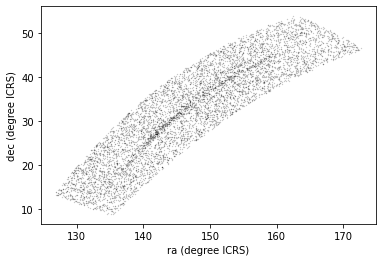

In [26]:
x = candidate_table['ra']
y = candidate_table['dec']
plt.plot(x, y, 'ko', markersize=0.3, alpha=0.3)

plt.xlabel('ra (degree ICRS)')
plt.ylabel('dec (degree ICRS)');

Here we can see why it was useful to transform these coordinates.  In ICRS, it is more difficult to identity the stars near the centerline of GD-1.

So, before we move on to the next step, let's collect the code we used to transform the coordinates and make a Pandas `DataFrame`:

In [27]:
from pyia import GaiaData

def make_dataframe(table):
    """Transform coordinates from ICRS to GD-1 frame.
    
    table: Astropy Table
    
    returns: Pandas DataFrame
    """
    gaia_data = GaiaData(table)

    c_sky = gaia_data.get_skycoord(distance=8*u.kpc, 
                                   radial_velocity=0*u.km/u.s)
    c_gd1 = gc.reflex_correct(
                c_sky.transform_to(gc.GD1Koposov10))

    df = table.to_pandas()
    df['phi1'] = c_gd1.phi1
    df['phi2'] = c_gd1.phi2
    df['pm_phi1'] = c_gd1.pm_phi1_cosphi2
    df['pm_phi2'] = c_gd1.pm_phi2
    return df

Here's how we can use this function:

In [28]:
candidate_df = make_dataframe(candidate_table)

And let's see the results.

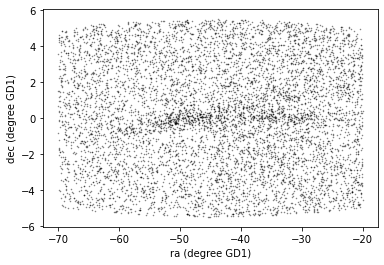

In [29]:
x = candidate_df['phi1']
y = candidate_df['phi2']

plt.plot(x, y, 'ko', markersize=0.5, alpha=0.5)

plt.xlabel('ra (degree GD1)')
plt.ylabel('dec (degree GD1)');

We're starting to see GD-1 more clearly.

We can compare this figure with one of these panels in Figure 1 from the original paper:

<img height="150" src="https://github.com/datacarpentry/astronomy-python/raw/gh-pages/fig/gd1-2.png">

<img height="150" src="https://github.com/datacarpentry/astronomy-python/raw/gh-pages/fig/gd1-4.png">

The top panel shows stars selected based on proper motion only, so it is comparable to our figure (although notice that it covers a wider region).

In the next lesson, we will use photometry data from Pan-STARRS to do a second round of filtering, and see if we can replicate the bottom panel.

We'll also learn how to add annotations like the ones in the figure from the paper, and customize the style of the figure to present the results clearly and compellingly.

## Saving the DataFrame

Let's save this `DataFrame` so we can pick up where we left off without running this query again.

In [30]:
!rm -f gd1_candidates.hdf5

In [31]:
filename = 'gd1_candidates.hdf5'

candidate_df.to_hdf(filename, 'candidate_df')

We can use `ls` to confirm that the file exists and check the size:

In [32]:
!ls -lh gd1_candidates.hdf5

-rw-rw-r-- 1 downey downey 756K Nov 18 19:07 gd1_candidates.hdf5


If you are using Windows, `ls` might not work; in that case, try:

```
!dir gd1_candidates.hdf5
```

## CSV

Pandas can write a variety of other formats, [which you can read about here](https://pandas.pydata.org/pandas-docs/stable/user_guide/io.html).

We won't cover all of them, but one other important one is [CSV](https://en.wikipedia.org/wiki/Comma-separated_values), which stands for "comma-separated values".

CSV is a plain-text format with minimal formatting requirements, so it can be read and written by pretty much any tool that works with data.  In that sense, it is the "least common denominator" of data formats.

However, it has an important limitation: some information about the data gets lost in translation, notably the data types.  If you read a CSV file from someone else, you might need some additional information to make sure you are getting it right.

Also, CSV files tend to be big, and slow to read and write.

With those caveats, here's how to write one:

In [33]:
candidate_df.to_csv('gd1_candidates.csv')

We can check the file size like this:

In [34]:
!ls -lh gd1_candidates.csv

-rw-rw-r-- 1 downey downey 1.6M Nov 18 19:07 gd1_candidates.csv


The CSV file about 2 times bigger than the HDF5 file (so that's not that bad, really).

We can see the first few lines like this:

In [35]:
!head -3 gd1_candidates.csv

,source_id,ra,dec,pmra,pmdec,parallax,parallax_error,radial_velocity,phi1,phi2,pm_phi1,pm_phi2
0,635559124339440000,137.58671691646745,19.1965441084838,-3.770521900009566,-12.490481778113859,0.7913934419894347,0.2717538145759051,,-59.63048941944396,-1.21648525150429,-7.3613627125974945,-0.5926328820644919
1,635860218726658176,138.5187065217173,19.09233926905897,-5.941679495793577,-11.346409129876392,0.30745551377348623,0.19946557779138105,,-59.247329893833296,-2.0160784008206476,-7.52712608464053,1.7487794924176672


The CSV file contains the names of the columns, but not the data types.

We can read the CSV file back like this:

In [36]:
read_back_csv = pd.read_csv('gd1_candidates.csv')

Let's compare the first few rows of `candidate_df` and `read_back_csv`

In [37]:
candidate_df.head(3)

,source_id,ra,dec,pmra,pmdec,parallax,parallax_error,radial_velocity,phi1,phi2,pm_phi1,pm_phi2
0,635559124339440000,137.586717,19.196544,-3.770522,-12.490482,0.791393,0.271754,NaN,-59.630489,-1.216485,-7.361363,-0.592633
1,635860218726658176,138.518707,19.092339,-5.941679,-11.346409,0.307456,0.199466,NaN,-59.247330,-2.016078,-7.527126,1.748779
2,635674126383965568,138.842874,19.031798,-3.897001,-12.702780,0.779463,0.223692,NaN,-59.133391,-2.306901,-7.560608,-0.741800


In [38]:
read_back_csv.head(3)

,Unnamed: 0,source_id,ra,dec,pmra,pmdec,parallax,parallax_error,radial_velocity,phi1,phi2,pm_phi1,pm_phi2
0,0,635559124339440000,137.586717,19.196544,-3.770522,-12.490482,0.791393,0.271754,NaN,-59.630489,-1.216485,-7.361363,-0.592633
1,1,635860218726658176,138.518707,19.092339,-5.941679,-11.346409,0.307456,0.199466,NaN,-59.247330,-2.016078,-7.527126,1.748779
2,2,635674126383965568,138.842874,19.031798,-3.897001,-12.702780,0.779463,0.223692,NaN,-59.133391,-2.306901,-7.560608,-0.741800


Notice that the index in `candidate_df` has become an unnamed column in `read_back_csv`.  The Pandas functions for writing and reading CSV files provide options to avoid that problem, but this is an example of the kind of thing that can go wrong with CSV files.

## Summary

In the previous lesson we downloaded data for a large number of stars and then selected a small fraction of them based on proper motion.

In this lesson, we improved this process by writing a more complex query that uses the database to select stars based on proper motion.  This process requires more computation on the Gaia server, but then we're able to either:

1. Search the same region and download less data, or

2. Search a larger region while still downloading a manageable amount of data.

In the next lesson, we'll learn about the databased `JOIN` operation and use it to download photometry data from Pan-STARRS.

## Best practices

* When possible, "move the computation to the data"; that is, do as much of the work as possible on the database server before downloading the data.

* For most applications, saving data in FITS or HDF5 is better than CSV.  FITS and HDF5 are binary formats, so the files are usually smaller, and they store metadata, so you don't lose anything when you read the file back.

* On the other hand, CSV is a "least common denominator" format; that is, it can be read by practically any application that works with data.